In [1]:
%load_ext autoreload
%autoreload 2

import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt
import pydot
from tensorflow.keras.utils import plot_model
import pc  # custom module

# Check CUDA support
if len(tf.config.list_physical_devices("GPU")) > 0:
    print("CUDA enabled.")
else:
    print("CUDA not enabled.")

# Path to dataset
data_folder = "/app/data"
# Training parameters
EP = 100
BS = 64
# Image resolution
RES = (224, 224)
# Random seed
SEED = 42

# Enable automatic mixed precision (not compatible with my GPU GeForce GTX 1060 6GB)
# tf.keras.mixed_precision.set_global_policy('mixed_float16')

CUDA enabled.


In [2]:
!ls /app/data

 Abra		     Dugtrio	  Jynx	       Nidorino    Seadra
 Aerodactyl	     Eevee	  Kabuto       Ninetales   Seaking
 Alakazam	     Ekans	  Kabutops     Oddish	   Seel
'Alolan Sandslash'   Electabuzz   Kadabra      Omanyte	   Shellder
 Arbok		     Electrode	  Kakuna       Omastar	   Slowbro
 Arcanine	     Exeggcute	  Kangaskhan   Onix	   Slowpoke
 Articuno	     Exeggutor	  Kingler      Paras	   Snorlax
 Beedrill	     Farfetchd	  Koffing      Parasect    Spearow
 Bellsprout	     Fearow	  Krabby       Persian	   Squirtle
 Blastoise	     Flareon	  Lapras       Pidgeot	   Starmie
 Bulbasaur	     Gastly	  Lickitung    Pidgeotto   Staryu
 Butterfree	     Gengar	  Machamp      Pidgey	   Tangela
 Caterpie	     Geodude	  Machoke      Pikachu	   Tauros
 Chansey	     Gloom	  Machop       Pinsir	   Tentacool
 Charizard	     Golbat	  Magikarp     Poliwag	   Tentacruel
 Charmander	     Goldeen	  Magmar       Poliwhirl   Vaporeon
 Charmeleon	     Golduck	  Magnemite    Poliwrath   Venomoth
 Clefable	     G

In [3]:
data_dict = pc.create_dataset(
    data_folder,
    epochs=EP,
    batch_size=BS,
    res=RES,
    seed=SEED,
)

In [4]:
train_dataset = data_dict["train_dataset"]
val_dataset = data_dict["val_dataset"]
test_dataset = data_dict["test_dataset"]
train_len = data_dict["train_len"]
val_len = data_dict["val_len"]
test_len = data_dict["test_len"]
label_encoder = data_dict["label_encoder"]
# print(list(label_encoder.classes_))
# np.save('classes.npy', label_encoder.classes_)
print(f"Number of training samples: {train_len}")
print(f"Number of validation samples: {val_len}")
print(f"Number of test samples: {test_len}")

Number of training samples: 5471
Number of validation samples: 594
Number of test samples: 594


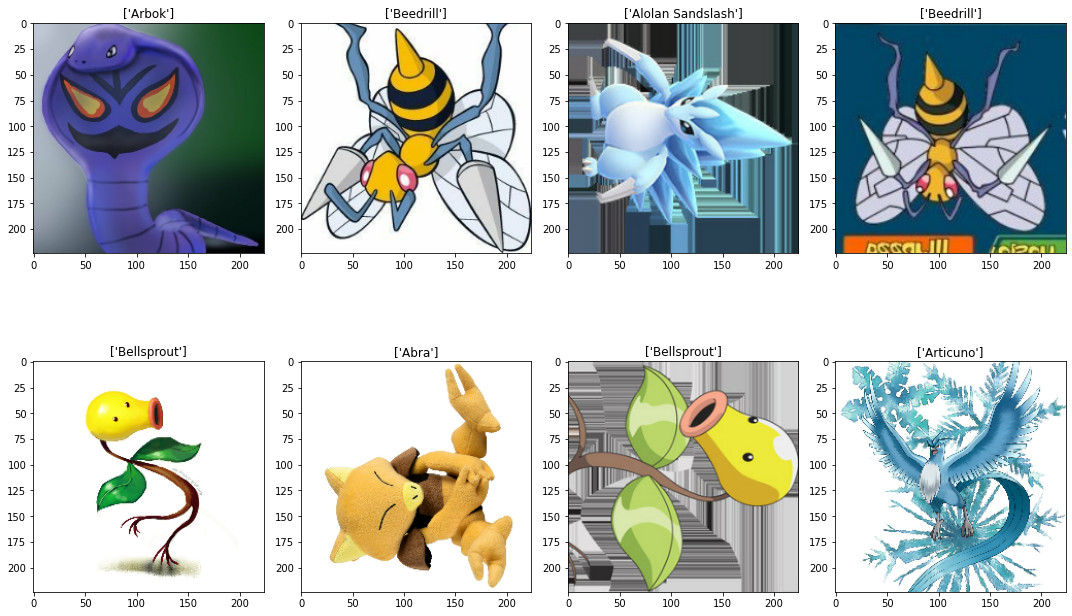

In [5]:
plt.figure(figsize=(15, 10))

# Iterate over batches
for (image_batch, label_batch) in train_dataset:
    # Iterate over elements in batch
    for i, (image, label) in enumerate(zip(image_batch[:8], label_batch[:8])):
        plt.subplot(2, 4, i + 1)
        plt.title(label_encoder.inverse_transform([label]))
        plt.imshow((255 * image.numpy()).astype(np.uint8))
    break

plt.tight_layout()
plt.show()

Training: done
Validation: done
Test: done


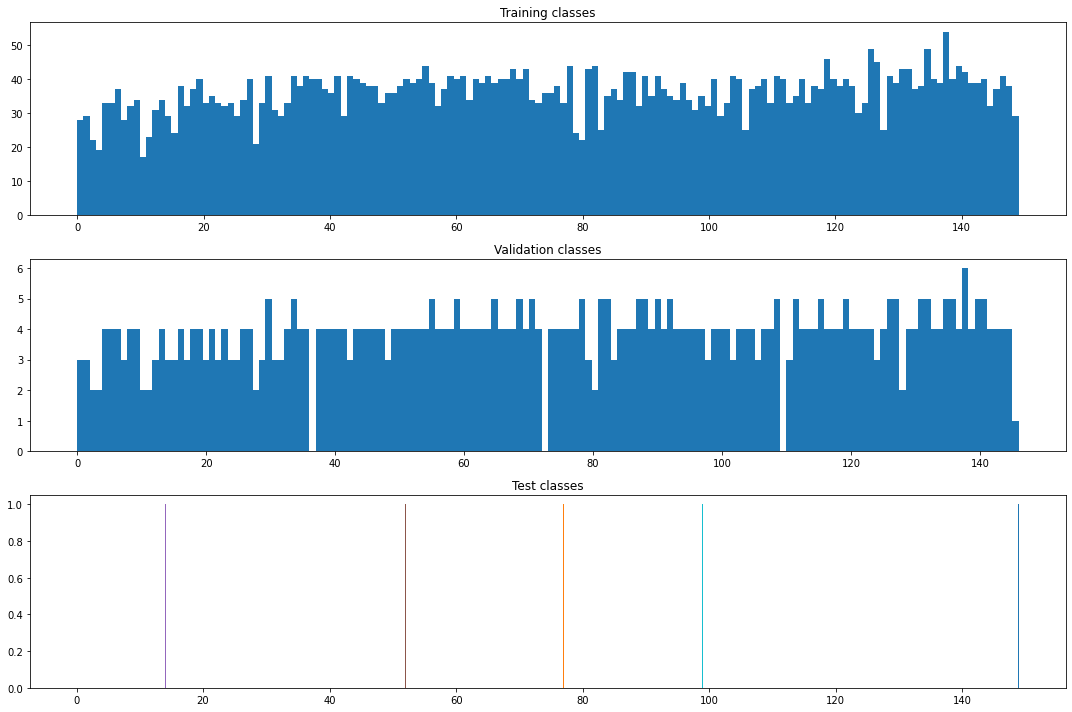

In [6]:
train_labels = []
train_it = iter(train_dataset)
for i in range(train_len // BS):
    (_, label_batch) = next(train_it)
    for label in label_batch:
        train_labels.append(label.numpy())
print("Training: done")
        
val_labels = []
val_it = iter(val_dataset)
for i in range(val_len // BS):
    (_, label_batch) = next(val_it)
    for label in label_batch:
        val_labels.append(label.numpy())
print("Validation: done")

test_labels = []
test_it = iter(test_dataset)
for i, (_, label) in enumerate(test_it):
    test_labels.append(label.numpy())
print("Test: done")

plt.figure(figsize=(15, 10))
plt.subplot(3, 1, 1)
plt.hist(train_labels, bins=150)
plt.title("Training classes")
plt.subplot(3, 1, 2)
plt.hist(val_labels, bins=150)
plt.title("Validation classes")
plt.subplot(3, 1, 3)
plt.hist(test_labels, bins=150)
plt.title("Test classes")
plt.tight_layout()
plt.show()

Model: "Pokemon-classifier"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 224, 224, 16)      448       
_________________________________________________________________
batch_normalization (BatchNo (None, 224, 224, 16)      64        
_________________________________________________________________
re_lu (ReLU)                 (None, 224, 224, 16)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 32)      4640      
_________________________________________________________________
batch_normalization_1 (Batch (None, 112, 112, 32

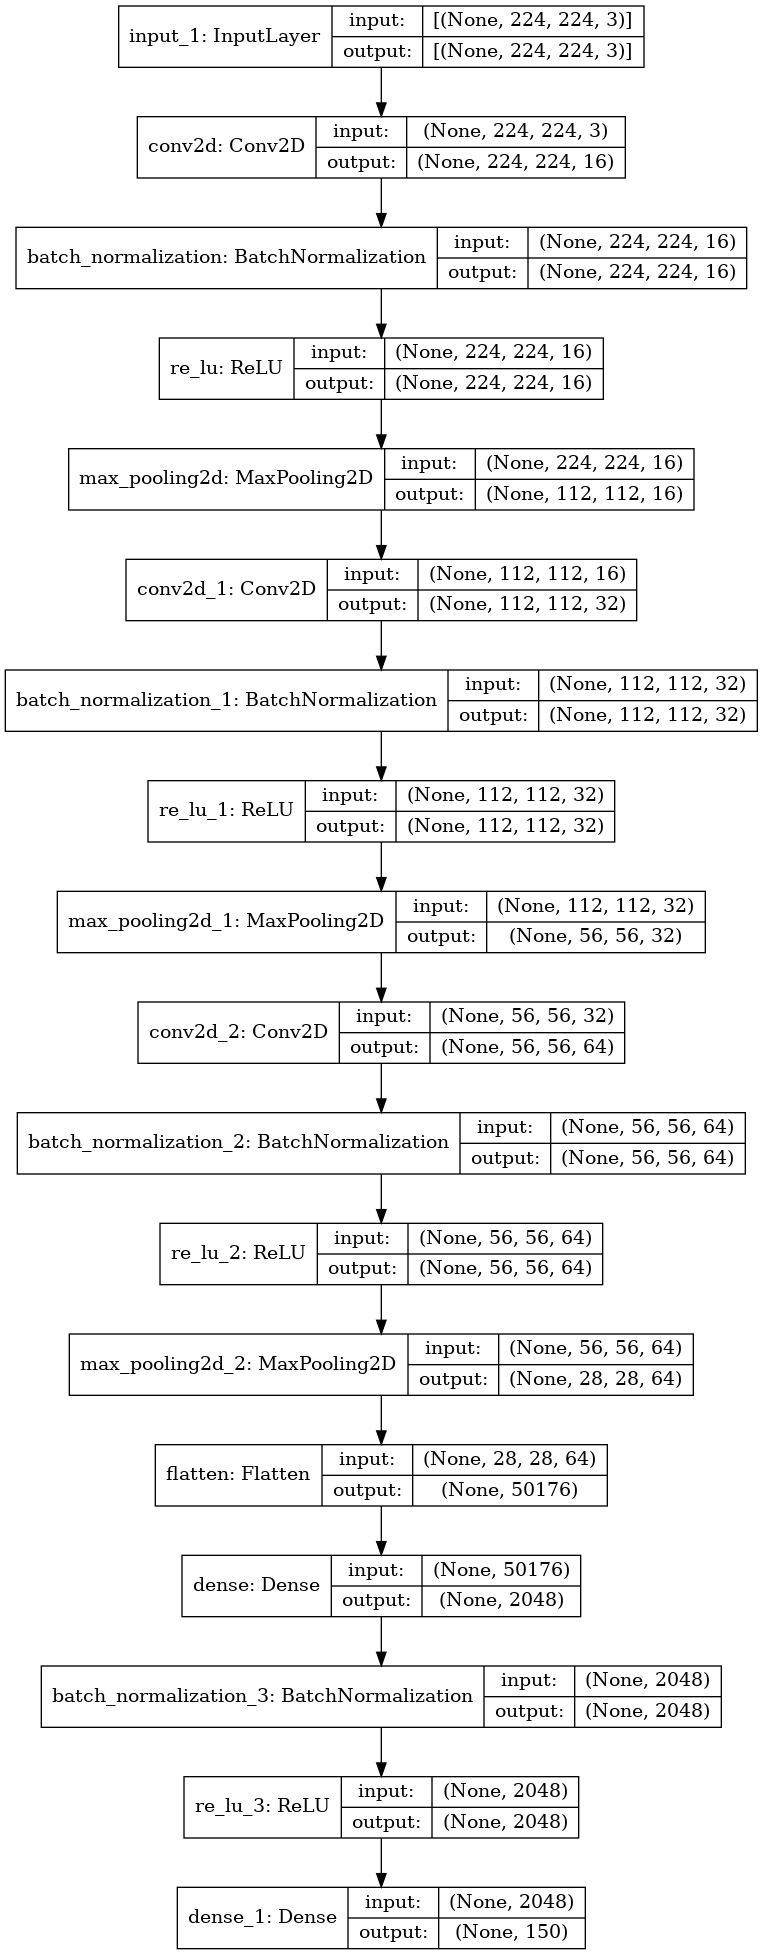

In [7]:
model = pc.create_model(n_conv=3, use_bn=True, res=RES)
model.summary()
plot_model(model, show_shapes=True)

In [8]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(
    train_dataset,
    epochs=EP,
    callbacks=[callback],
    steps_per_epoch=train_len // BS,
    validation_data=val_dataset,
    validation_steps=val_len // BS
)

Epoch 1/100
85/85 [==============================] - 19s 204ms/step - loss: 8.5790 - accuracy: 0.0338 - val_loss: 6.8700 - val_accuracy: 0.0087
Epoch 2/100
85/85 [==============================] - 11s 130ms/step - loss: 6.8869 - accuracy: 0.0298 - val_loss: 5.8763 - val_accuracy: 0.0330
Epoch 3/100
85/85 [==============================] - 11s 129ms/step - loss: 5.9287 - accuracy: 0.0451 - val_loss: 5.6033 - val_accuracy: 0.0382
Epoch 4/100
85/85 [==============================] - 11s 129ms/step - loss: 5.1814 - accuracy: 0.0627 - val_loss: 4.9997 - val_accuracy: 0.0608
Epoch 5/100
85/85 [==============================] - 11s 129ms/step - loss: 4.7271 - accuracy: 0.0756 - val_loss: 6.6606 - val_accuracy: 0.0486
Epoch 6/100
85/85 [==============================] - 11s 129ms/step - loss: 4.4665 - accuracy: 0.0917 - val_loss: 5.3272 - val_accuracy: 0.0799
Epoch 7/100
85/85 [==============================] - 11s 130ms/step - loss: 4.2288 - accuracy: 0.0947 - val_loss: 4.5674 - val_accuracy:

85/85 [==============================] - 11s 131ms/step - loss: 0.0319 - accuracy: 0.9965 - val_loss: 0.0183 - val_accuracy: 0.9983
Epoch 58/100
85/85 [==============================] - 11s 130ms/step - loss: 0.0330 - accuracy: 0.9956 - val_loss: 0.0155 - val_accuracy: 0.9983
Epoch 59/100
85/85 [==============================] - 11s 130ms/step - loss: 0.0315 - accuracy: 0.9941 - val_loss: 0.0606 - val_accuracy: 0.9896
Epoch 60/100
85/85 [==============================] - 11s 130ms/step - loss: 0.0337 - accuracy: 0.9935 - val_loss: 0.0618 - val_accuracy: 0.9896
Epoch 61/100
85/85 [==============================] - 11s 130ms/step - loss: 0.0374 - accuracy: 0.9926 - val_loss: 0.0402 - val_accuracy: 0.9913
Epoch 62/100
85/85 [==============================] - 11s 130ms/step - loss: 0.0458 - accuracy: 0.9908 - val_loss: 0.0449 - val_accuracy: 0.9931
Epoch 63/100
85/85 [==============================] - 11s 130ms/step - loss: 0.0337 - accuracy: 0.9943 - val_loss: 0.0167 - val_accuracy: 0.998

In [9]:
# Save model (tensorflow standard format)
model.save("model_name")

INFO:tensorflow:Assets written to: model_no_softmax/assets


In [10]:
test_dict = model.evaluate(
    test_dataset,
    steps=test_len,
    return_dict=True
)

594/594 [==============================] - 3s 5ms/step - loss: 0.0155 - accuracy: 0.9983


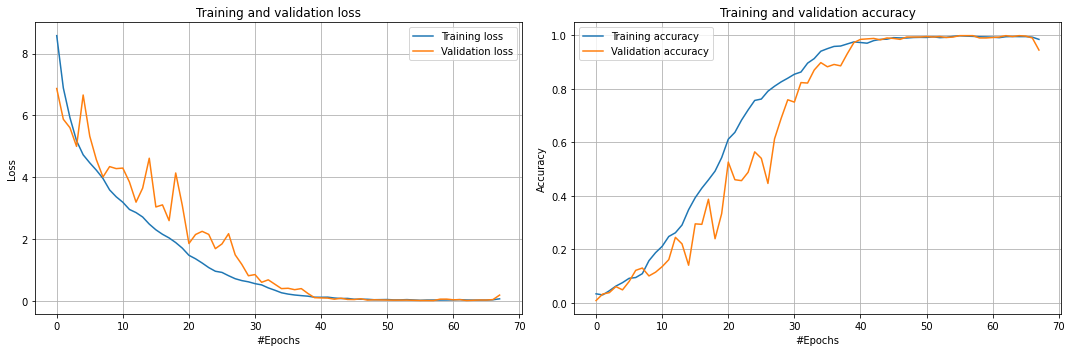

In [11]:
plt.figure(figsize=(15, 5))  # set graph dimension

# 1. First graph

plt.subplot(1, 2, 1)  # creates 1 subplot out of 2

plt.title("Training and validation loss")
plt.plot(history.history["loss"], label="Training loss")
plt.plot(history.history["val_loss"], label="Validation loss")
plt.legend()
plt.xlabel("#Epochs")
plt.ylabel("Loss")
plt.grid()

# 2. Second Graph

plt.subplot(1, 2, 2)  # creates 1 subplot out of 2

plt.title("Training and validation accuracy")
plt.plot(history.history["accuracy"], label="Training accuracy")
plt.plot(history.history["val_accuracy"], label="Validation accuracy")
plt.legend()
plt.xlabel("#Epochs")
plt.ylabel("Accuracy")
plt.grid()

plt.tight_layout()
plt.show()

[('Eevee', 0.71598876), ('Raticate', 0.10326181), ('Vulpix', 0.050285846), ('Marowak', 0.043136287), ('Zapdos', 0.030175028)]


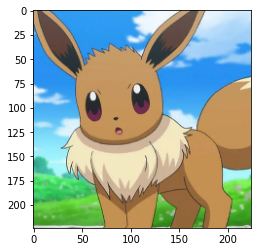

In [29]:
from tensorflow.keras.utils import load_img, img_to_array
from matplotlib import pyplot as plt

img = load_img("./evee_1.jpg", target_size=(224, 224))
plt.imshow(img)
img = img_to_array(img, dtype=np.float32)
img /= 255
img = np.expand_dims(img, axis=0)
score = pc.top_k_predictions(model, img, label_encoder)
print(score)

In [28]:
import tensorflow as tf
import os
model = tf.keras.models.load_model('./model_best_100')

In [19]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the model.
with open('model_name.tflite', 'wb') as f:
    f.write(tflite_model)


INFO:tensorflow:Assets written to: /tmp/tmpq3z6795o/assets


INFO:tensorflow:Assets written to: /tmp/tmpq3z6795o/assets


In [ ]:
#import tensorflow as tf
#import os

#model = tf.keras.models.load_model("./model_best_100")
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.SIZE]
converter.target_spec.supported_types = [tf.float16]
tflite_quant_model = converter.convert()#save converted quantization model to tflite format
open("qa_model_no_soft.tflite", "wb").write(tflite_quant_model)

In [13]:
#model = tf.keras.models.load_model("./model_best_100")
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quant_model = converter.convert()#save converted quantization model to tflite format
open("qa_model_no_soft_8bit.tflite", "wb").write(tflite_quant_model)

INFO:tensorflow:Assets written to: /tmp/tmpyraljrm6/assets


103108592

In [15]:
import tensorflow as tf
from tensorflow.keras.utils import load_img, img_to_array
from matplotlib import pyplot as plt
import numpy as np

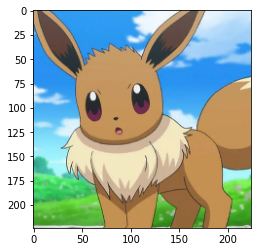

In [25]:
# Load TFLite model and allocate tensors.
# import cv2

TFLITE_MODEL="./qa_model_best100_8bit.tflite"
interpreter = tf.lite.Interpreter(TFLITE_MODEL)
interpreter.allocate_tensors()

# Get input and output tensors
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Load image
img = load_img("./evee_1.jpg", target_size=(224, 224))
plt.imshow(img)
img = img_to_array(img, dtype=np.float32)
img /= 255
img = np.expand_dims(img, axis=0)

input_tensor = np.array(img, dtype=np.float32)
# Load the TFLite model and allocate tensors.
interpreter.set_tensor(input_details[0]['index'], input_tensor)
interpreter.invoke()

# Get output
output_data = interpreter.get_tensor(output_details[0]['index'])

In [26]:
import pc

(top_k_scores, top_k_idx) = tf.math.top_k(output_data, 5)
top_k_scores = np.squeeze(top_k_scores.numpy(), axis=0)
top_k_idx = np.squeeze(top_k_idx.numpy(), axis=0)
top_k_labels = label_encoder.inverse_transform(top_k_idx)
print (top_k_labels, top_k_scores)

['Eevee' 'Raticate' 'Vulpix' 'Marowak' 'Zapdos'] [0.70600057 0.10232402 0.05526398 0.0450505  0.03152084]


In [27]:
output_data = interpreter.get_tensor(output_details[0]['index'])
print(output_data)

[[4.35865968e-06 4.25308684e-07 5.94792189e-04 2.77140160e-08
  2.01416219e-06 2.12225365e-03 2.14017800e-05 1.89644888e-05
  2.29962779e-07 3.08161107e-04 6.30781916e-09 1.26064310e-06
  4.26007496e-08 5.94394351e-06 8.43752059e-04 1.16534415e-04
  3.90132263e-05 1.23022211e-04 1.18666539e-05 4.05367655e-06
  3.15565958e-05 3.93209893e-06 4.69739171e-05 4.87376823e-08
  3.82316539e-05 2.67961295e-04 5.53921247e-08 6.90967590e-03
  6.99748099e-08 2.39608344e-05 4.07164218e-04 7.06000566e-01
  1.01368967e-08 2.96373696e-06 1.93803995e-09 9.50709567e-04
  8.82869790e-06 1.91791900e-04 3.26656713e-03 8.75970818e-06
  3.59743410e-07 4.07602874e-06 2.99385065e-05 4.50146545e-05
  1.76381818e-07 1.25048928e-06 1.75179866e-05 1.79091364e-06
  7.81131530e-05 6.97431688e-06 4.44123056e-03 1.07648113e-04
  2.14620115e-07 1.93707201e-05 1.18925609e-02 2.65458971e-06
  2.12963150e-05 9.81037296e-09 8.26028046e-09 1.17795920e-04
  1.21065955e-06 1.68226888e-05 3.58546386e-05 3.78805009e-04
  1.8470